# MiniProject  👁️ Image Recognition multiclass classification Landscapes  
##  🏢🌲🧊⛰️🌊🏙️
### Wesley, Keven, Didier, Celso  

### Loading Data 📦

In [73]:
import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from pathlib import Path
import os
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np 
from keras.preprocessing import image
# Load data set x contains the actual images in 32 x 32  
# composed of 32x32 images with 3 color channels 
# mnist = keras.datasets.fashion_mnist
# img = image.load_img("/home/celso/Documents/DeepLearning/ImageClassification/MiniProject/Data/seg_train/buildings/0.jpg", target_size=(28, 28),color_mode="grayscale")
 
image_size = (40,40)

class_labels = [
    "buildings",
     "forest",
     "glacier",
     "mountain",
     "sea",
     "street"
]

data_path = "/home/celso/Documents/DeepLearning/ImageClassification/MiniProject/Data/seg_"

x_train = np.ndarray((0,30,30)) 
x_test = np.ndarray((0,30,30)) 

def make_Y(TypeOfSet):
    path=data_path+TypeOfSet
    Data_dir_content = os.listdir(path)
    resulting_y = []

    for label in Data_dir_content:
        label_dir_content = os.listdir(path+f"/{label}")

        for _ in range(len(label_dir_content)):
            resulting_y.append(class_labels.index(label))

    return resulting_y

def make_X(TypeOfSet):
    path=data_path+TypeOfSet
    Data_dir_content = os.listdir(path)
    resulting_X = np.ndarray((0,30,30))

    for label in Data_dir_content:
        label_dir_path=path+f"/{label}"
        label_dir_content = os.listdir(label_dir_path)

        for element in label_dir_content:
           processed_img = prepare_img_for_model(label_dir_path+f"/{element}")
           resulting_X = np.append(resulting_X,processed_img,axis=0)

    return resulting_X

def prepare_img_for_model(path):
    img = image.load_img(path,target_size=(30,30),color_mode="grayscale")
    image_as_array = image.img_to_array(img)
    image_reshaped = image_as_array.reshape(30,30)
    return np.expand_dims( image_reshaped, axis=0)

x_test = make_X("test")
x_train =make_X("train")


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


y_train = make_Y("train")
y_test = make_Y("test")

y_train = to_categorical(y_train, 6)
y_test = to_categorical(y_test, 6)
  

In [84]:
model = Sequential()

# 2D convolutional layers for images 1D can fit for other kind like Sound
# Params:
# 1 filters :how many differnet filters should be in the layer, one filter by pattern
# 2 kernel_size : size of the window used when creating the tiles for each image
# 3 padding: in case the kernel size doesnt match the corner ignore or fill with 0
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same",activation='relu', input_shape=(30,30,1),name="Conv2D_1"))
model.add(Conv2D(filters=32, kernel_size=(3,3),activation='relu', name="Conv2D_2"))

#max pooling
model.add(MaxPooling2D(pool_size=(2,2)))
#Dropout, randomly cut connections, normally used between [25-50]%
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3),padding="same", activation='relu', name="Conv2D_3"))
model.add(Conv2D(filters=64, kernel_size=(3,3),activation='relu',name="Conv2D_4"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#To transition from Convolutional layers to Dense layers we need to tell karas that we no longer want to use 2D data
model.add(Flatten())
model.add(Dense(512,activation='relu', name="DenseLayer_1"))
model.add(Dropout(0.5))
# when doing classificaton with more than one kind of object we almost always use softmax activator for the output
model.add(Dense(6, activation="softmax", name="output_layer"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 Conv2D_2 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 Conv2D_3 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 Conv2D_4 (Conv2D)           (None, 12, 12, 64)        36928     
                                                      

In [85]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [86]:
# batch size is how many images we want to fit in to the network at once during the training,
# too low it takes too long to train, to high we will run out of memory. typical [32-128]
# tensorboard --logdir=/home/celso/Documents/DeepLearning/ImageClassification/MNIST_fashion/logs
FirstRun = "/home/celso/Documents/DeepLearning/ImageClassification/MiniProject/logs/FirstRun"
# PARAMS: 
# image 30 x 30 x 1 
# batch_size=24,
# epochs=3,


SecondRun = "/home/celso/Documents/DeepLearning/ImageClassification/MiniProject/logs/SecondRun"
logger =  keras.callbacks.TensorBoard(
    log_dir=FirstRun,
    # log_dir=SecondRun,
    write_graph=True, #log the structure of the model
    histogram_freq =5 #how each layer is working (for every 5 passes of the training data)
)

model.fit(
    x_train,
    y_train,
    batch_size=24,
    epochs=3,
    validation_data=(x_test, y_test),
    shuffle=True,
    callbacks=[logger]
)


Epoch 1/3
585/585 [==============================] - 21s 35ms/step - loss: 1.2053 - accuracy: 0.5076 - val_loss: 1.0158 - val_accuracy: 0.6080
Epoch 2/3
  1/585 [..............................] - ETA: 17s - loss: 0.8206 - accuracy: 0.7083

2022-03-25 15:48:13.733164: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 283115520 exceeds 10% of free system memory.


585/585 [==============================] - 22s 37ms/step - loss: 0.9254 - accuracy: 0.6442 - val_loss: 0.8195 - val_accuracy: 0.6783
Epoch 3/3
585/585 [==============================] - 22s 38ms/step - loss: 0.7896 - accuracy: 0.7037 - val_loss: 0.7308 - val_accuracy: 0.7270


In [87]:
test_error_rate = model.evaluate(x_test, y_test, verbose=0)
print("The mean squared error (MSE) for the test data set is: {}".format(test_error_rate))

The mean squared error (MSE) for the test data set is: [0.7308340668678284, 0.7269999980926514]


In [88]:
# Save neural network structure
model_structure = model.to_json()
f = Path("/home/celso/Documents/DeepLearning/ImageClassification/MiniProject/SavedModel/model_structure.json")
f.write_text(model_structure)

# Save neural network's trained weights
model.save_weights("/home/celso/Documents/DeepLearning/ImageClassification/MiniProject/SavedModel/model_weights.h5")

[0. 0. 0. 0. 0. 1.]
This is image is a glacier - Likelihood: 1.000000


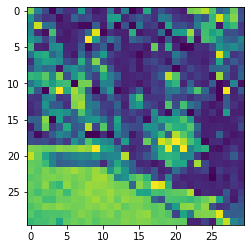

In [103]:

from keras.models import model_from_json
from pathlib import Path
from keras.preprocessing import image
import numpy as np
 
# Load the json file that contains the model's structure

f = Path("/home/celso/Documents/DeepLearning/ImageClassification/MiniProject/SavedModel/model_structure.json")
model_structure = f.read_text()

# Recreate the Keras model object from the json data
model = model_from_json(model_structure)

# Re-load the model's trained weights
model.load_weights("/home/celso/Documents/DeepLearning/ImageClassification/MiniProject/SavedModel/model_weights.h5")

# Load an image file to test, resizing it to 32x32 pixels (as required by this model)

 
# img = image.load_img("/home/celso/Documents/DeepLearning/ImageClassification/MiniProject/Data/seg_test/sea/20072.jpg", target_size=(30, 30),color_mode="grayscale")
img = image.load_img("/home/celso/Documents/DeepLearning/ImageClassification/MiniProject/Data/seg_test/mountain/20157.jpg", target_size=(30, 30),color_mode="grayscale")
# img = image.load_img("/home/celso/Documents/DeepLearning/ImageClassification/MiniProject/Data/seg_test/glacier/20059.jpg", target_size=(30, 30),color_mode="grayscale")

# Convert the image to a numpy array

image_to_test = image.img_to_array(img)

# Add a fourth dimension to the image (since Keras expects a list of images, not a single image)
# list_of_images = np.expand_dims(y_test, axis=0)

#predicting with an image from test set
plt.imshow(x_test[1])

# list_of_images = np.expand_dims(x_test[0], axis=0)
list_of_images = np.expand_dims(image_to_test, axis=0)

print(y_test[0])
# Make a prediction using the model
results = model.predict(list_of_images)

# Since we are only testing one image, we only need to check the first result
single_result = results[0]

# We will get a likelihood score for all 10 possible classes. Find out which class had the highest score.
most_likely_class_index = int(np.argmax(single_result))
class_likelihood = single_result[most_likely_class_index]

# Get the name of the most likely class
class_label = class_labels[most_likely_class_index]

# Print the result
print("This is image is a {} - Likelihood: {:2f}".format(class_label, class_likelihood))